### Goal
Audit and clean messy marketing funnel data using SQL inside a Python note then analyze the cleaned data using Python.

### Data
Raw marketing (synthetic) funnel data with marketing events and customer orders

In [1]:
!pip install duckdb

In [2]:
import duckdb
import pandas as pd

In [3]:
events = pd.read_csv("data/marketing_events_raw.csv")

In [4]:
events.head()

,event_id,event_name,event_ts_raw,user_id,email_hash,phone,session_id,utm_source,utm_medium,campaign,device,country,order_id,amount_raw,currency,status,refund_raw,is_bot
0,1,pageview,2024-04-23T23:15:33Z,347.0,95a73da6441e2e4c62d9267c3b3e7c2c,NaN,u8fpus810d5w,Email,(none),spring_sale,iOS,PK,NaN,NaN,usd,NaN,NaN,False
1,2,add-to-cart,2024-02-01 23:25:36,NaN,05796498a2f5c79b61939a36a5782f71,405010980.0,tvegdte5n0wt,tiktok,NaN,welcome,ios,uae,NaN,NaN,usd,NaN,NaN,False
2,3,sign_up,2024-01-09,291.0,fe9b55944e4a1a0d9e7dea5c7fbb3db1,NaN,z4ese0qly334,tiktok,paid_social,SPRING_SALE,iOS,AE,NaN,NaN,currency,NaN,NaN,False
3,4,PAGEVIEW,2024-04-18,333.0,aee7d641c92489f74415e606179f0f6d,NaN,4webqlhsiynu,tiktok,CPC,Ramadan2024,android,NaN,NaN,NaN,د.إ,NaN,NaN,False
4,5,PAGEVIEW,2024-06-18T17:26:22Z,13.0,dae3bcb4ba1e39724604d3dd630ad619,NaN,qt6txadfq3di,TikTok,(none),brand,ios,UAE,NaN,NaN,usd,NaN,NaN,False


In [5]:
con = duckdb.connect()

In [6]:
con.register("events_raw", events)

In [7]:
#sanity check
con.execute("SELECT COUNT(*) FROM events_raw").fetchall()

[(8000,)]

#### Audit Question 1
What kinds of event names do we have and how messy are they?

In [8]:
con.execute("""SELECT event_name, COUNT(*) AS n FROM events_raw 
GROUP BY event_name
ORDER BY n DESC""").df()

,event_name,n
0,PAGEVIEW,912
1,pv,880
2,pageview,864
3,page_view,861
4,PageView,841
5,addtocart,301
6,add_to_cart,290
7,ATC,283
8,AddToCart,279
9,add-to-cart,262


#### Audit Question 2
What raw timestamp values exist, and how often?

In [9]:
con.execute("""SELECT event_ts_raw, COUNT(*) AS n FROM events_raw
GROUP BY event_ts_raw
ORDER BY n DESC
LIMIT 20""").df()

,event_ts_raw,n
0,None,54
1,not a time,30
2,2024-06-13,16
3,2024-02-08,14
4,2024-03-09,14
5,2024-06-16,13
6,2024-04-08,13
7,2024-02-29,12
8,2024-06-08,12
9,2024-02-07,12


Timestamp is mostly usable, but contains explicit invalid and missing values

#### Audit Question 3
How many events are missing timestamps?


In [10]:
con.execute("""SELECT event_ts_raw, COUNT(*) AS n FROM events_raw
WHERE event_ts_raw IS NULL
OR event_ts_raw = ''
OR event_ts_raw IN ('not a time')
GROUP BY event_ts_raw
ORDER BY n DESC""").df()

,event_ts_raw,n
0,None,54
1,not a time,30


only about 1% have bad timestamps, which cannot participate in time-based analysis so it would be better to drop these rows during cleaning.

In [11]:
#keep only rows where event_ts_raw is present
con.execute("""SELECT * from events_raw WHERE event_ts_raw IS NOT NULL
AND event_ts_raw <> '' 
AND event_ts_raw <> 'not a time'""").df()

,event_id,event_name,event_ts_raw,user_id,email_hash,phone,session_id,utm_source,utm_medium,campaign,device,country,order_id,amount_raw,currency,status,refund_raw,is_bot
0,1,pageview,2024-04-23T23:15:33Z,347.0,95a73da6441e2e4c62d9267c3b3e7c2c,NaN,u8fpus810d5w,Email,(none),spring_sale,iOS,PK,None,None,usd,None,None,False
1,2,add-to-cart,2024-02-01 23:25:36,NaN,05796498a2f5c79b61939a36a5782f71,405010980.0,tvegdte5n0wt,tiktok,None,welcome,ios,uae,None,None,usd,None,None,False
2,3,sign_up,2024-01-09,291.0,fe9b55944e4a1a0d9e7dea5c7fbb3db1,NaN,z4ese0qly334,tiktok,paid_social,SPRING_SALE,iOS,AE,None,None,currency,None,None,False
3,4,PAGEVIEW,2024-04-18,333.0,aee7d641c92489f74415e606179f0f6d,NaN,4webqlhsiynu,tiktok,CPC,Ramadan2024,android,None,None,None,د.إ,None,None,False
4,5,PAGEVIEW,2024-06-18T17:26:22Z,13.0,dae3bcb4ba1e39724604d3dd630ad619,NaN,qt6txadfq3di,TikTok,(none),brand,ios,UAE,None,None,usd,None,None,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7911,7996,page_view,2024-05-30,410.0,a7ca299802089c2f6c048868bb06b28d,NaN,3fy0x8er4f30,(direct),(none),ramadan,web,UAE,None,None,USD,None,None,False
7912,7997,pv,2024-02-27T13:39:04Z,NaN,3a01ed5a994ee24f1a88e87cc05f5c84,NaN,iwmamhyb4k8u,facebook,None,ramadan,android,SE,None,None,د.إ,None,None,False
7913,7998,pv,2024-05-23,170.0,c5abdd65ddf25e50b7f4e14eb6b431c7,NaN,fvx06xcz1ja0,unknown,email,None,ANDROID,None,None,None,US$,None,None,False
7914,7999,checkout_start,02/05/2024 05:56,274.0,e777ff7c1c3047dbb06f689c342f0417,NaN,egni4nn5mzwr,Google,CPC,brand,Web,AE,None,None,AED,None,None,False


#### Audit Question 4
How many logical events exist vs how many messy variants

In [12]:
con.execute("""SELECT event_name, COUNT(*) AS n FROM events_raw
WHERE event_name IS NOT NULL
AND event_name <> ''
GROUP BY event_name
ORDER BY n DESC""").df()

,event_name,n
0,PAGEVIEW,912
1,pv,880
2,pageview,864
3,page_view,861
4,PageView,841
5,addtocart,301
6,add_to_cart,290
7,ATC,283
8,AddToCart,279
9,add-to-cart,262


In [13]:
con.execute("""
CREATE OR REPLACE VIEW clean_events AS
SELECT
  *,
  CASE
    WHEN LOWER(event_name) IN ('page_view','pageview','pv')
      THEN 'page_view'

    WHEN LOWER(event_name) IN ('add_to_cart','addtocart','atc','add-to-cart')
      THEN 'add_to_cart'

    WHEN LOWER(event_name) IN ('begin_checkout','checkout_start','start_checkout')
      THEN 'begin_checkout'

    WHEN LOWER(event_name) IN ('signup','sign_up','register','create_account')
      THEN 'signup'

    WHEN LOWER(event_name) IN ('purchase','order_complete','order_completed','buy')
      THEN 'purchase'

    WHEN LOWER(event_name) IN ('refund','chargeback')
      THEN 'refund_or_chargeback'

    ELSE 'other'
  END AS event_type
FROM events_raw
WHERE
  event_ts_raw IS NOT NULL
  AND event_ts_raw <> ''
  AND event_ts_raw <> 'not a time'
""")


In [14]:
#sanity check 
con.execute("""SELECT event_type, COUNT(*) AS n FROM clean_events
GROUP BY event_type
ORDER BY n DESC""").df()

,event_type,n
0,page_view,4315
1,add_to_cart,1399
2,signup,927
3,begin_checkout,583
4,purchase,386
5,other,188
6,refund_or_chargeback,118


In [15]:
#sanity check
con.execute("""SELECT event_type, COUNT(DISTINCT user_id) AS users FROM clean_events
WHERE user_id IS NOT NULL
GROUP BY event_type
ORDER BY users DESC""").df()

,event_type,users
0,page_view,450
1,add_to_cart,409
2,signup,365
3,begin_checkout,281
4,purchase,232
5,other,138
6,refund_or_chargeback,95


In [16]:
#sanity check
con.execute("""SELECT COUNT(*) AS total_events, 
COUNT(DISTINCT user_id) AS total_users
FROM clean_events""").df()

,total_events,total_users
0,7916,450


### Analytics & Funnels
How many unique users reached each step **at least once**

In [17]:
con.execute("""SELECT event_type, COUNT(DISTINCT user_id) AS users FROM clean_events
GROUP BY event_type
ORDER BY users DESC""").df()

,event_type,users
0,page_view,450
1,add_to_cart,409
2,signup,365
3,begin_checkout,281
4,purchase,232
5,other,138
6,refund_or_chargeback,95


Most users drop between signup and checkout. 

##### Hypotheses: 
- Signup friction (email verification or long forms)
- Users browsing/registering but not ready to buy
- Checkout UX issues
- Missing pricing/shopping info

#### Conversion Rates

In [18]:
con.execute("""SELECT DISTINCT user_id AS users, event_type FROM clean_events
WHERE user_id IS NOT NULL""").df()

,users,event_type
0,347.0,page_view
1,291.0,signup
2,6.0,page_view
3,119.0,signup
4,200.0,page_view
...,...,...
1965,433.0,begin_checkout
1966,380.0,begin_checkout
1967,365.0,begin_checkout
1968,288.0,refund_or_chargeback


In [19]:
con.execute("""
WITH user_event AS (
  SELECT DISTINCT user_id, event_type
  FROM clean_events
  WHERE user_id IS NOT NULL
),
funnel AS (
  SELECT
    SUM(CASE WHEN event_type = 'page_view' THEN 1 ELSE 0 END) AS page_view_users,
    SUM(CASE WHEN event_type = 'add_to_cart' THEN 1 ELSE 0 END) AS add_to_cart_users,
    SUM(CASE WHEN event_type = 'signup' THEN 1 ELSE 0 END) AS signup_users,
    SUM(CASE WHEN event_type = 'begin_checkout' THEN 1 ELSE 0 END) AS begin_checkout_users,
    SUM(CASE WHEN event_type = 'purchase' THEN 1 ELSE 0 END) AS purchase_users
  FROM user_event
)
SELECT
  *,
  ROUND(add_to_cart_users * 1.0 / page_view_users, 3) AS atc_rate,
  ROUND(signup_users * 1.0 / add_to_cart_users, 3) AS signup_rate,
  ROUND(begin_checkout_users * 1.0 / signup_users, 3) AS checkout_rate,
  ROUND(purchase_users * 1.0 / begin_checkout_users, 3) AS purchase_rate,
  ROUND(purchase_users * 1.0 / page_view_users, 3) AS overall_rate
FROM funnel;
""").df()

,page_view_users,add_to_cart_users,signup_users,begin_checkout_users,purchase_users,atc_rate,signup_rate,checkout_rate,purchase_rate,overall_rate
0,450.0,409.0,365.0,281.0,232.0,0.909,0.892,0.77,0.826,0.516


In [20]:
funnel_df = con.execute("""WITH user_event AS (
  SELECT DISTINCT user_id, event_type
  FROM clean_events
  WHERE user_id IS NOT NULL
),
funnel AS (
  SELECT
    SUM(CASE WHEN event_type = 'page_view' THEN 1 ELSE 0 END) AS page_view_users,
    SUM(CASE WHEN event_type = 'add_to_cart' THEN 1 ELSE 0 END) AS add_to_cart_users,
    SUM(CASE WHEN event_type = 'signup' THEN 1 ELSE 0 END) AS signup_users,
    SUM(CASE WHEN event_type = 'begin_checkout' THEN 1 ELSE 0 END) AS begin_checkout_users,
    SUM(CASE WHEN event_type = 'purchase' THEN 1 ELSE 0 END) AS purchase_users
  FROM user_event
),
rates AS (
  SELECT
    *,
    add_to_cart_users * 1.0 / page_view_users AS atc_rate,
    signup_users * 1.0 / add_to_cart_users AS signup_rate,
    begin_checkout_users * 1.0 / signup_users AS checkout_rate,
    purchase_users * 1.0 / begin_checkout_users AS purchase_rate
  FROM funnel
)
SELECT 'page_view' AS step, page_view_users AS users, 1.0 AS conversion_rate FROM rates
UNION ALL
SELECT 'add_to_cart', add_to_cart_users, atc_rate FROM rates
UNION ALL
SELECT 'signup', signup_users, signup_rate FROM rates
UNION ALL
SELECT 'begin_checkout', begin_checkout_users, checkout_rate FROM rates
UNION ALL
SELECT 'purchase', purchase_users, purchase_rate FROM rates;""").df()

In [21]:
funnel_df

,step,users,conversion_rate
0,page_view,450.0,1.000000
1,add_to_cart,409.0,0.908889
2,signup,365.0,0.892421
3,begin_checkout,281.0,0.769863
4,purchase,232.0,0.825623


#### Funnel Charts

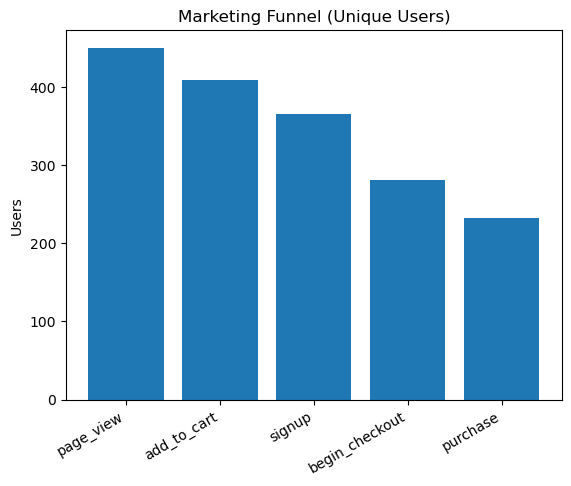

In [22]:
import matplotlib.pyplot as plt

plt.figure()
plt.bar(funnel_df["step"], funnel_df["users"])
plt.xticks(rotation=30, ha="right")
plt.ylabel("Users")
plt.title("Marketing Funnel (Unique Users)")
plt.show()

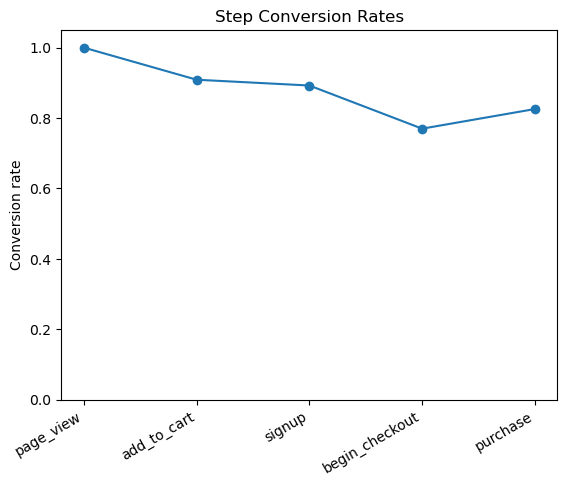

In [23]:
plt.figure()
plt.plot(funnel_df["step"], funnel_df["conversion_rate"], marker="o")
plt.xticks(rotation=30, ha="right")
plt.ylabel("Conversion rate")
plt.title("Step Conversion Rates")
plt.ylim(0, 1.05)
plt.show()

#### Conclusion
- Out of 450 unique users, approximately 51% reached purchase, with the largest drop-off occurring between signup and checkout initiation.
- This suggests that post-signup friction, like checkout UX, pricing transparency, or readiness to purchase, may be a stronger barrier than initial acquisition or cart engagement.